# Start Code

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import h5py
import numpy as np
import os
import cv2
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.preprocessing import StandardScaler
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc,roc_curve
from matplotlib import pyplot as plt

In [ ]:
x_dataset=[]
y_dataset=[]
src=os.listdir('/content/gdrive/MyDrive/Breast MRI Data Analysis/Healthy')
i=0
for filename in src:
    full_file_name='/content/gdrive/MyDrive/Breast MRI Data Analysis/Healthy/'+filename
    x=cv2.imread(full_file_name)
    x=np.array(x,dtype='float32')
    y=1
    y=np.array(y,dtype='float32')
    x=x/255.0
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    i=i+1


In [ ]:

src=os.listdir('/content/gdrive/MyDrive/Breast MRI Data Analysis/Sick')
for filename in src:
    full_file_name='/content/gdrive/MyDrive/Breast MRI Data Analysis/Sick/'+filename
    x=cv2.imread(full_file_name)
    x=np.array(x,dtype='float32')
    y=0
    y=np.array(y,dtype='float32')
    x=x/255.0
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    i=i+1

In [ ]:
X_dataset=np.array(x_dataset)
Y_dataset=np.array(y_dataset)
Y_dataset=Y_dataset.reshape((1480,1))

In [ ]:
from sklearn.utils import shuffle
X_dataset,Y_dataset=shuffle(X_dataset,Y_dataset,random_state=0)

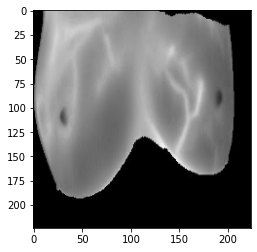

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_dataset[60])
plt.show()

In [ ]:
Healthy_len=0
Sick_len=0
for i in range(1480):
    if Y_dataset[i]==0:
        Sick_len+=1
    else:
        Healthy_len+=1
print(Healthy_len)
print(Sick_len)

740
740


<Axes: >

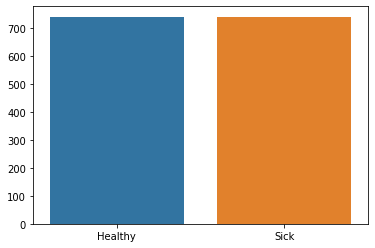

In [ ]:

import seaborn as sns
sns.barplot(x=['Healthy','Sick'],y=[Healthy_len,Sick_len])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_dataset,Y_dataset,test_size=0.10)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
folds=list(StratifiedShuffleSplit(n_splits=1,random_state=0,test_size=0.15).split(x_train,y_train))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=8,
                                     width_shift_range=0.03,
                                     height_shift_range=0.03,
                                     shear_range=0.25,
                                     zoom_range=0.45,
                                     horizontal_flip=True)
val_datagen = ImageDataGenerator(zoom_range=0.45)

# CNN 2 layer

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)       

In [ ]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h51'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model1.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict1_1=model1.predict(x_val)
    Y_predict1_1=np.float32(y_predict1_1>0.50)
    l=len(y_val)
    Y_predict1_1=np.reshape(Y_predict1_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 1.7777 - accuracy: 0.5406 - auc: 0.5344 - precision: 0.5379 - recall: 0.6116
Epoch 1: val_accuracy improved from -inf to 0.48500, saving model to best_model.h51


36/36 [==============================] - 19s 465ms/step - loss: 1.7777 - accuracy: 0.5406 - auc: 0.5344 - precision: 0.5379 - recall: 0.6116 - val_loss: 0.6934 - val_accuracy: 0.4850 - val_auc: 0.5185 - val_precision: 0.4873 - val_recall: 0.9796
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.5627 - auc: 0.5955 - precision: 0.5706 - recall: 0.5255
Epoch 2: val_accuracy improved from 0.48500 to 0.51500, saving model to best_model.h51


36/36 [==============================] - 16s 440ms/step - loss: 0.6781 - accuracy: 0.5627 - auc: 0.5955 - precision: 0.5706 - recall: 0.5255 - val_loss: 0.6823 - val_accuracy: 0.5150 - val_auc: 0.5609 - val_precision: 0.5048 - val_recall: 0.5408
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5654 - auc: 0.5796 - precision: 0.5546 - recall: 0.6872
Epoch 3: val_accuracy did not improve from 0.51500
36/36 [==============================] - 14s 377ms/step - loss: 0.6845 - accuracy: 0.5654 - auc: 0.5796 - precision: 0.5546 - recall: 0.6872 - val_loss: 0.6857 - val_accuracy: 0.5000 - val_auc: 0.6059 - val_precision: 0.4853 - val_recall: 0.3367
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.5822 - auc: 0.6217 - precision: 0.5886 - recall: 0.5606
Epoch 4: val_accuracy improved from 0.51500 to 0.53000, saving model to best_model.h51


36/36 [==============================] - 16s 443ms/step - loss: 0.6726 - accuracy: 0.5822 - auc: 0.6217 - precision: 0.5886 - recall: 0.5606 - val_loss: 0.6748 - val_accuracy: 0.5300 - val_auc: 0.5968 - val_precision: 0.5244 - val_recall: 0.4388
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5883 - auc: 0.6081 - precision: 0.5827 - recall: 0.6380
Epoch 5: val_accuracy improved from 0.53000 to 0.59000, saving model to best_model.h51


36/36 [==============================] - 16s 446ms/step - loss: 0.6763 - accuracy: 0.5883 - auc: 0.6081 - precision: 0.5827 - recall: 0.6380 - val_loss: 0.6620 - val_accuracy: 0.5900 - val_auc: 0.6414 - val_precision: 0.5816 - val_recall: 0.5816
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.6166 - auc: 0.6460 - precision: 0.6186 - recall: 0.6186
Epoch 6: val_accuracy improved from 0.59000 to 0.62000, saving model to best_model.h51


36/36 [==============================] - 16s 449ms/step - loss: 0.6639 - accuracy: 0.6166 - auc: 0.6460 - precision: 0.6186 - recall: 0.6186 - val_loss: 0.6601 - val_accuracy: 0.6200 - val_auc: 0.6560 - val_precision: 0.5948 - val_recall: 0.7041
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.6034 - auc: 0.6556 - precision: 0.6119 - recall: 0.5764
Epoch 7: val_accuracy improved from 0.62000 to 0.65500, saving model to best_model.h51


36/36 [==============================] - 17s 481ms/step - loss: 0.6543 - accuracy: 0.6034 - auc: 0.6556 - precision: 0.6119 - recall: 0.5764 - val_loss: 0.6471 - val_accuracy: 0.6550 - val_auc: 0.7100 - val_precision: 0.6239 - val_recall: 0.7449
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.6290 - auc: 0.6712 - precision: 0.6269 - recall: 0.6467
Epoch 8: val_accuracy did not improve from 0.65500
36/36 [==============================] - 14s 379ms/step - loss: 0.6477 - accuracy: 0.6290 - auc: 0.6712 - precision: 0.6269 - recall: 0.6467 - val_loss: 0.6478 - val_accuracy: 0.6550 - val_auc: 0.7023 - val_precision: 0.6330 - val_recall: 0.7041
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.6228 - auc: 0.6739 - precision: 0.6241 - recall: 0.6274
Epoch 9: val_accuracy improved from 0.65500 to 0.69500, saving model to best_model.h51


36/36 [==============================] - 16s 442ms/step - loss: 0.6459 - accuracy: 0.6228 - auc: 0.6739 - precision: 0.6241 - recall: 0.6274 - val_loss: 0.6360 - val_accuracy: 0.6950 - val_auc: 0.7140 - val_precision: 0.6457 - val_recall: 0.8367
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6369 - auc: 0.6734 - precision: 0.6317 - recall: 0.6661
Epoch 10: val_accuracy did not improve from 0.69500
7/7 [==============================] - 0s 15ms/step


In [ ]:
model1.evaluate(train_datagen.flow(x_train,y_train))
model1.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 269ms/step - loss: 0.6619 - accuracy: 0.6000 - auc: 0.6522 - precision: 0.5738 - recall: 0.7143


[0.6618611812591553,
 0.6000000238418579,
 0.6521608829498291,
 0.5737704634666443,
 0.7142857313156128]

In [ ]:
y_predict1_2=model1.predict(x_test)
Y_predict1_2=np.float32(y_predict1_2>0.50)
l=len(y_test)
Y_predict1_2=np.reshape(Y_predict1_2,(l,1))
print(Y_predict1_2)

5/5 [==============================] - 0s 32ms/step
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f11 = f1_score(y_test, Y_predict1_2)
test_accuracy1 = accuracy_score(y_test, Y_predict1_2)
kappa1 = cohen_kappa_score(y_test, Y_predict1_2)
auc1 = roc_auc_score(y_test, Y_predict1_2)

In [ ]:
print(auc1)
print(f11)
print(kappa1)
print(test_accuracy1)

0.676169590643275
0.6756756756756757
0.3518248175182481
0.6756756756756757


# CNN 3 Layer

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 54, 54, 32)       

In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h52'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history2=model2.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict2_1=model2.predict(x_val)
    Y_predict2_1=np.float32(y_predict2_1>0.50)
    l=len(y_val)
    Y_predict2_1=np.reshape(Y_predict2_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.5124 - auc: 0.5218 - precision: 0.5189 - recall: 0.4333
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to best_model.h52


36/36 [==============================] - 17s 406ms/step - loss: 0.8918 - accuracy: 0.5124 - auc: 0.5218 - precision: 0.5189 - recall: 0.4333 - val_loss: 0.6930 - val_accuracy: 0.5100 - val_auc: 0.5198 - val_precision: 0.4940 - val_recall: 0.4227
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5265 - auc: 0.5677 - precision: 0.5390 - recall: 0.4123
Epoch 2: val_accuracy improved from 0.51000 to 0.59000, saving model to best_model.h52


36/36 [==============================] - 15s 398ms/step - loss: 0.6884 - accuracy: 0.5265 - auc: 0.5677 - precision: 0.5390 - recall: 0.4123 - val_loss: 0.6789 - val_accuracy: 0.5900 - val_auc: 0.6269 - val_precision: 0.5620 - val_recall: 0.7010
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.5398 - auc: 0.5762 - precision: 0.5468 - recall: 0.5018
Epoch 3: val_accuracy did not improve from 0.59000
36/36 [==============================] - 12s 323ms/step - loss: 0.6847 - accuracy: 0.5398 - auc: 0.5762 - precision: 0.5468 - recall: 0.5018 - val_loss: 0.6803 - val_accuracy: 0.5850 - val_auc: 0.6459 - val_precision: 0.5673 - val_recall: 0.6082
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.5707 - auc: 0.6018 - precision: 0.5755 - recall: 0.5614
Epoch 4: val_accuracy improved from 0.59000 to 0.60000, saving model to best_model.h52


36/36 [==============================] - 14s 396ms/step - loss: 0.6756 - accuracy: 0.5707 - auc: 0.6018 - precision: 0.5755 - recall: 0.5614 - val_loss: 0.6793 - val_accuracy: 0.6000 - val_auc: 0.6810 - val_precision: 0.5578 - val_recall: 0.8454
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.5883 - auc: 0.6215 - precision: 0.5793 - recall: 0.6667
Epoch 5: val_accuracy improved from 0.60000 to 0.61500, saving model to best_model.h52


36/36 [==============================] - 14s 387ms/step - loss: 0.6728 - accuracy: 0.5883 - auc: 0.6215 - precision: 0.5793 - recall: 0.6667 - val_loss: 0.6660 - val_accuracy: 0.6150 - val_auc: 0.6850 - val_precision: 0.6250 - val_recall: 0.5155
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.6025 - auc: 0.6444 - precision: 0.6087 - recall: 0.5895
Epoch 6: val_accuracy improved from 0.61500 to 0.62000, saving model to best_model.h52


36/36 [==============================] - 14s 394ms/step - loss: 0.6628 - accuracy: 0.6025 - auc: 0.6444 - precision: 0.6087 - recall: 0.5895 - val_loss: 0.6486 - val_accuracy: 0.6200 - val_auc: 0.6970 - val_precision: 0.5897 - val_recall: 0.7113
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.5981 - auc: 0.6396 - precision: 0.6051 - recall: 0.5807
Epoch 7: val_accuracy did not improve from 0.62000
36/36 [==============================] - 13s 349ms/step - loss: 0.6632 - accuracy: 0.5981 - auc: 0.6396 - precision: 0.6051 - recall: 0.5807 - val_loss: 0.6483 - val_accuracy: 0.6150 - val_auc: 0.7071 - val_precision: 0.6111 - val_recall: 0.5670
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6228 - auc: 0.6605 - precision: 0.6307 - recall: 0.6053
Epoch 8: val_accuracy improved from 0.62000 to 0.64500, saving model to best_model.h52


36/36 [==============================] - 14s 390ms/step - loss: 0.6558 - accuracy: 0.6228 - auc: 0.6605 - precision: 0.6307 - recall: 0.6053 - val_loss: 0.6327 - val_accuracy: 0.6450 - val_auc: 0.7111 - val_precision: 0.6182 - val_recall: 0.7010
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.6157 - auc: 0.6631 - precision: 0.6087 - recall: 0.6632
Epoch 9: val_accuracy did not improve from 0.64500
36/36 [==============================] - 13s 354ms/step - loss: 0.6521 - accuracy: 0.6157 - auc: 0.6631 - precision: 0.6087 - recall: 0.6632 - val_loss: 0.6338 - val_accuracy: 0.6400 - val_auc: 0.7294 - val_precision: 0.6214 - val_recall: 0.6598
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.6299 - auc: 0.6755 - precision: 0.6248 - recall: 0.6632
Epoch 10: val_accuracy did not improve from 0.64500
7/7 [==============================] - 0s 15ms/step


In [ ]:
model2.evaluate(train_datagen.flow(x_train,y_train))
model2.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 266ms/step - loss: 0.6628 - accuracy: 0.6150 - auc: 0.6886 - precision: 0.5633 - recall: 0.9175


[0.6628134250640869,
 0.6150000095367432,
 0.6886197328567505,
 0.5632911324501038,
 0.9175257682800293]

In [ ]:
y_predict2_2=model2.predict(x_test)
Y_predict2_2=np.float32(y_predict2_2>0.50)
l=len(y_test)
Y_predict2_2=np.reshape(Y_predict2_2,(l,1))
print(Y_predict2_2)

5/5 [==============================] - 0s 23ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f12 = f1_score(y_test, Y_predict2_2)
test_accuracy2 = accuracy_score(y_test, Y_predict2_2)
kappa2 = cohen_kappa_score(y_test, Y_predict2_2)
auc2 = roc_auc_score(y_test, Y_predict2_2)

In [ ]:
print(auc2)
print(f12)
print(kappa2)
print(test_accuracy2)

0.6370614035087719
0.7005649717514125
0.27665068240501667
0.6418918918918919


# CNN 4 Layer

In [ ]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 54, 54, 32)       

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h53'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history3=model3.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict3_1=model3.predict(x_val)
    Y_predict3_1=np.float32(y_predict3_1>0.50)
    l=len(y_val)
    Y_predict3_1=np.reshape(Y_predict3_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.5247 - auc: 0.5404 - precision: 0.5497 - recall: 0.3105
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to best_model.h53


36/36 [==============================] - 18s 418ms/step - loss: 0.7266 - accuracy: 0.5247 - auc: 0.5404 - precision: 0.5497 - recall: 0.3105 - val_loss: 0.6920 - val_accuracy: 0.5100 - val_auc: 0.5950 - val_precision: 0.4973 - val_recall: 0.9485
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.5477 - auc: 0.5631 - precision: 0.5553 - recall: 0.5105
Epoch 2: val_accuracy did not improve from 0.51000
36/36 [==============================] - 15s 411ms/step - loss: 0.6868 - accuracy: 0.5477 - auc: 0.5631 - precision: 0.5553 - recall: 0.5105 - val_loss: 0.6935 - val_accuracy: 0.4850 - val_auc: 0.6063 - val_precision: 0.4850 - val_recall: 1.0000
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5371 - auc: 0.5717 - precision: 0.5432 - recall: 0.5070
Epoch 3: val_accuracy improved from 0.51000 to 0.57500, saving model to best_model.h53


36/36 [==============================] - 14s 401ms/step - loss: 0.6844 - accuracy: 0.5371 - auc: 0.5717 - precision: 0.5432 - recall: 0.5070 - val_loss: 0.6883 - val_accuracy: 0.5750 - val_auc: 0.6657 - val_precision: 0.5357 - val_recall: 0.9278
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.5928 - auc: 0.6180 - precision: 0.6023 - recall: 0.5632
Epoch 4: val_accuracy improved from 0.57500 to 0.58500, saving model to best_model.h53


36/36 [==============================] - 15s 408ms/step - loss: 0.6720 - accuracy: 0.5928 - auc: 0.6180 - precision: 0.6023 - recall: 0.5632 - val_loss: 0.6849 - val_accuracy: 0.5850 - val_auc: 0.6449 - val_precision: 0.5432 - val_recall: 0.9072
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.5610 - auc: 0.5783 - precision: 0.5597 - recall: 0.6000
Epoch 5: val_accuracy did not improve from 0.58500
36/36 [==============================] - 13s 350ms/step - loss: 0.6818 - accuracy: 0.5610 - auc: 0.5783 - precision: 0.5597 - recall: 0.6000 - val_loss: 0.6921 - val_accuracy: 0.4900 - val_auc: 0.6816 - val_precision: 0.4874 - val_recall: 1.0000
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.5592 - auc: 0.5921 - precision: 0.5577 - recall: 0.6018
Epoch 6: val_accuracy did not improve from 0.58500
36/36 [==============================] - 13s 351ms/step - loss: 0.6819 - accuracy: 0.5592 - auc: 0.5921 - precision:

In [ ]:
model3.evaluate(train_datagen.flow(x_train,y_train))
model3.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 331ms/step - loss: 0.6827 - accuracy: 0.5350 - auc: 0.6848 - precision: 0.5110 - recall: 0.9588


[0.6826953291893005,
 0.5350000262260437,
 0.6847662925720215,
 0.5109890103340149,
 0.9587628841400146]

In [ ]:
y_predict3_2=model3.predict(x_test)
Y_predict3_2=np.float32(y_predict3_2>0.50)
l=len(y_test)
Y_predict3_2=np.reshape(Y_predict3_2,(l,1))
print(Y_predict3_2)

5/5 [==============================] - 0s 24ms/step
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f13 = f1_score(y_test, Y_predict3_2)
test_accuracy3 = accuracy_score(y_test, Y_predict3_2)
kappa3 = cohen_kappa_score(y_test, Y_predict3_2)
auc3 = roc_auc_score(y_test, Y_predict3_2)

In [ ]:
print(auc3)
print(f13)
print(kappa3)
print(test_accuracy3)

0.5771198830409358
0.7081339712918661
0.15752146323254956
0.5878378378378378


# CNN 5 Layer

In [ ]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_5 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 110, 110, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 108, 32)      9248      
                                                      

In [ ]:
model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h54'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model4.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict4_1=model4.predict(x_val)
    Y_predict4_1=np.float32(y_predict4_1>0.50)
    l=len(y_val)
    Y_predict4_1=np.reshape(Y_predict4_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 1.2804 - accuracy: 0.5018 - auc: 0.5197 - precision: 0.5217 - recall: 0.0635
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h54


36/36 [==============================] - 31s 483ms/step - loss: 1.2804 - accuracy: 0.5018 - auc: 0.5197 - precision: 0.5217 - recall: 0.0635 - val_loss: 0.6910 - val_accuracy: 0.5000 - val_auc: 0.6739 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.4841 - auc: 0.5024 - precision: 0.4868 - recall: 0.5538
Epoch 2: val_accuracy did not improve from 0.50000
36/36 [==============================] - 15s 404ms/step - loss: 0.6937 - accuracy: 0.4841 - auc: 0.5024 - precision: 0.4868 - recall: 0.5538 - val_loss: 0.6930 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5027 - auc: 0.5334 - precision: 0.5200 - recall: 0.0917
Epoch 3: val_accuracy improved from 0.50000 to 0.63000, saving model to best_model.h54


36/36 [==============================] - 17s 470ms/step - loss: 0.6922 - accuracy: 0.5027 - auc: 0.5334 - precision: 0.5200 - recall: 0.0917 - val_loss: 0.6900 - val_accuracy: 0.6300 - val_auc: 0.6123 - val_precision: 0.6300 - val_recall: 0.6300
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5680 - auc: 0.5982 - precision: 0.5712 - recall: 0.5520
Epoch 4: val_accuracy did not improve from 0.63000
36/36 [==============================] - 15s 401ms/step - loss: 0.6768 - accuracy: 0.5680 - auc: 0.5982 - precision: 0.5712 - recall: 0.5520 - val_loss: 0.6903 - val_accuracy: 0.5500 - val_auc: 0.5256 - val_precision: 0.5287 - val_recall: 0.9200
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.5698 - auc: 0.5973 - precision: 0.5735 - recall: 0.5503
Epoch 5: val_accuracy did not improve from 0.63000
36/36 [==============================] - 15s 405ms/step - loss: 0.6777 - accuracy: 0.5698 - auc: 0.5973 - precision:

7/7 [==============================] - 0s 28ms/step


In [ ]:
model4.evaluate(train_datagen.flow(x_train,y_train))
model4.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 279ms/step - loss: 0.6799 - accuracy: 0.6200 - auc: 0.7044 - precision: 0.5750 - recall: 0.9200


[0.6799482107162476,
 0.6200000047683716,
 0.7044000029563904,
 0.574999988079071,
 0.9200000166893005]

In [ ]:
y_predict4_1=model4.predict(x_test)
Y_predict4_1=np.float32(y_predict4_1>0.50)
l=len(y_test)
Y_predict4_1=np.reshape(Y_predict4_1,(l,1))
print(Y_predict4_1)

5/5 [==============================] - 1s 121ms/step
[[1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f14 = f1_score(y_test, Y_predict4_1)
test_accuracy4 = accuracy_score(y_test, Y_predict4_1)
kappa4 = cohen_kappa_score(y_test, Y_predict4_1)
auc4 = roc_auc_score(y_test, Y_predict4_1)

In [ ]:
print(auc4)
print(f14)
print(kappa4)
print(test_accuracy4)

0.5966371027346636
0.7263681592039802
0.20445660672400312
0.6283783783783784


# CNN 6 Layer

In [ ]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_8 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 108, 108, 32)      9248      
                                                                 
 conv2d_10 (Conv2D)          (None, 106, 106, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                  

In [ ]:
model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h55'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model5.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict5_1=model5.predict(x_val)
    Y_predict5_1=np.float32(y_predict5_1>0.50)
    l=len(y_val)
    Y_predict5_1=np.reshape(Y_predict5_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.5186 - auc: 0.5346 - precision: 0.5332 - recall: 0.3794
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to best_model.h55


36/36 [==============================] - 19s 443ms/step - loss: 0.7140 - accuracy: 0.5186 - auc: 0.5346 - precision: 0.5332 - recall: 0.3794 - val_loss: 0.6861 - val_accuracy: 0.5250 - val_auc: 0.6773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.5256 - auc: 0.5704 - precision: 0.5686 - recall: 0.2535
Epoch 2: val_accuracy improved from 0.52500 to 0.55500, saving model to best_model.h55


36/36 [==============================] - 15s 421ms/step - loss: 0.6859 - accuracy: 0.5256 - auc: 0.5704 - precision: 0.5686 - recall: 0.2535 - val_loss: 0.6747 - val_accuracy: 0.5550 - val_auc: 0.6068 - val_precision: 0.5517 - val_recall: 0.3368
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.5769 - auc: 0.6033 - precision: 0.5869 - recall: 0.5490
Epoch 3: val_accuracy improved from 0.55500 to 0.60500, saving model to best_model.h55


36/36 [==============================] - 15s 414ms/step - loss: 0.6793 - accuracy: 0.5769 - auc: 0.6033 - precision: 0.5869 - recall: 0.5490 - val_loss: 0.6669 - val_accuracy: 0.6050 - val_auc: 0.6334 - val_precision: 0.5952 - val_recall: 0.5263
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.6219 - auc: 0.6534 - precision: 0.6139 - recall: 0.6783
Epoch 4: val_accuracy did not improve from 0.60500
36/36 [==============================] - 14s 401ms/step - loss: 0.6622 - accuracy: 0.6219 - auc: 0.6534 - precision: 0.6139 - recall: 0.6783 - val_loss: 0.6734 - val_accuracy: 0.5700 - val_auc: 0.6428 - val_precision: 0.5319 - val_recall: 0.7895
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.6219 - auc: 0.6612 - precision: 0.6220 - recall: 0.6416
Epoch 5: val_accuracy improved from 0.60500 to 0.65000, saving model to best_model.h55


36/36 [==============================] - 15s 408ms/step - loss: 0.6539 - accuracy: 0.6219 - auc: 0.6612 - precision: 0.6220 - recall: 0.6416 - val_loss: 0.6512 - val_accuracy: 0.6500 - val_auc: 0.6986 - val_precision: 0.7049 - val_recall: 0.4526
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.6254 - auc: 0.6669 - precision: 0.6034 - recall: 0.7552
Epoch 6: val_accuracy did not improve from 0.65000
36/36 [==============================] - 13s 373ms/step - loss: 0.6557 - accuracy: 0.6254 - auc: 0.6669 - precision: 0.6034 - recall: 0.7552 - val_loss: 0.6628 - val_accuracy: 0.6050 - val_auc: 0.6440 - val_precision: 0.5816 - val_recall: 0.6000
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.6148 - auc: 0.6618 - precision: 0.6219 - recall: 0.6066
Epoch 7: val_accuracy did not improve from 0.65000
36/36 [==============================] - 13s 371ms/step - loss: 0.6545 - accuracy: 0.6148 - auc: 0.6618 - precision:

In [ ]:
model5.evaluate(train_datagen.flow(x_train,y_train))
model5.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 275ms/step - loss: 0.5885 - accuracy: 0.6900 - auc: 0.7715 - precision: 0.7200 - recall: 0.5684


[0.5884504914283752,
 0.6899999976158142,
 0.7715288400650024,
 0.7200000286102295,
 0.5684210658073425]

In [ ]:
y_predict5_2=model5.predict(x_test)
Y_predict5_2=np.float32(y_predict5_2>0.50)
l=len(y_test)
Y_predict5_2=np.reshape(Y_predict5_2,(l,1))
print(Y_predict5_2)

5/5 [==============================] - 0s 39ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f15 = f1_score(y_test, Y_predict5_2)
test_accuracy5 = accuracy_score(y_test, Y_predict5_2)
kappa5 = cohen_kappa_score(y_test, Y_predict5_2)
auc5 = roc_auc_score(y_test, Y_predict5_2)

In [ ]:
print(auc5)
print(f15)
print(kappa5)
print(test_accuracy5)

0.7276556776556776
0.7092198581560284
0.45036231884057976
0.722972972972973


# CNN 7 Layer

In [ ]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                    

In [ ]:
model6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h56'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model6.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict6_1=model6.predict(x_val)
    Y_predict6_1=np.float32(y_predict6_1>0.50)
    l=len(y_val)
    Y_predict6_1=np.reshape(Y_predict6_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5230 - auc: 0.5214 - precision: 0.5197 - recall: 0.7378
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to best_model.h56


36/36 [==============================] - 30s 459ms/step - loss: 0.6939 - accuracy: 0.5230 - auc: 0.5214 - precision: 0.5197 - recall: 0.7378 - val_loss: 0.6882 - val_accuracy: 0.5250 - val_auc: 0.6452 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5477 - auc: 0.5703 - precision: 0.5411 - recall: 0.6906
Epoch 2: val_accuracy improved from 0.52500 to 0.61000, saving model to best_model.h56


36/36 [==============================] - 15s 425ms/step - loss: 0.6881 - accuracy: 0.5477 - auc: 0.5703 - precision: 0.5411 - recall: 0.6906 - val_loss: 0.6726 - val_accuracy: 0.6100 - val_auc: 0.6428 - val_precision: 0.6889 - val_recall: 0.3263
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.5751 - auc: 0.5932 - precision: 0.5737 - recall: 0.6189
Epoch 3: val_accuracy did not improve from 0.61000
36/36 [==============================] - 13s 364ms/step - loss: 0.6790 - accuracy: 0.5751 - auc: 0.5932 - precision: 0.5737 - recall: 0.6189 - val_loss: 0.7021 - val_accuracy: 0.4750 - val_auc: 0.6445 - val_precision: 0.4750 - val_recall: 1.0000
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5371 - auc: 0.5430 - precision: 0.5284 - recall: 0.7797
Epoch 4: val_accuracy did not improve from 0.61000
36/36 [==============================] - 13s 366ms/step - loss: 0.6941 - accuracy: 0.5371 - auc: 0.5430 - precision:

36/36 [==============================] - 15s 424ms/step - loss: 0.6576 - accuracy: 0.6078 - auc: 0.6536 - precision: 0.6067 - recall: 0.6364 - val_loss: 0.6595 - val_accuracy: 0.6350 - val_auc: 0.6736 - val_precision: 0.6000 - val_recall: 0.6947
Epoch 10/10
36/36 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.6263 - auc: 0.6668 - precision: 0.6367 - recall: 0.6066
Epoch 10: val_accuracy improved from 0.63500 to 0.65000, saving model to best_model.h56


7/7 [==============================] - 0s 28ms/step


In [ ]:
model6.evaluate(train_datagen.flow(x_train,y_train))
model6.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 2s 272ms/step - loss: 0.6439 - accuracy: 0.6150 - auc: 0.6989 - precision: 0.6406 - recall: 0.4316


[0.643887996673584,
 0.6150000095367432,
 0.6988972425460815,
 0.640625,
 0.43157893419265747]

In [ ]:
y_predict6_2=model6.predict(x_test)
Y_predict6_2=np.float32(y_predict6_2>0.50)
l=len(y_test)
Y_predict6_2=np.reshape(Y_predict6_2,(l,1))
print(Y_predict6_2)

5/5 [==============================] - 1s 123ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f16 = f1_score(y_test, Y_predict6_2)
test_accuracy6 = accuracy_score(y_test, Y_predict6_2)
kappa6 = cohen_kappa_score(y_test, Y_predict6_2)
auc6 = roc_auc_score(y_test, Y_predict6_2)

In [ ]:
print(auc6)
print(f16)
print(kappa6)
print(test_accuracy6)

0.6706959706959705
0.6153846153846154
0.33501078360891445
0.6621621621621622


# CNN 8 Layer

In [ ]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model7.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_24 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 108, 108, 32)      9248      
                                                                 
 conv2d_26 (Conv2D)          (None, 106, 106, 32)      9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                 

In [ ]:
model7.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h57'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))

    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model7.fit(train_datagen.flow(x_train,y_train),epochs=10,validation_data=(x_val,y_val),callbacks=checkpoint)
    y_predict7_1=model7.predict(x_val)
    Y_predict7_1=np.float32(y_predict7_1>0.50)
    l=len(y_val)
    Y_predict7_1=np.reshape(Y_predict7_1,(l,1))

Fold 1
Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.5309 - auc: 0.5225 - precision: 0.5226 - recall: 0.7715
Epoch 1: val_accuracy improved from -inf to 0.49000, saving model to best_model.h57


36/36 [==============================] - 22s 468ms/step - loss: 0.7080 - accuracy: 0.5309 - auc: 0.5225 - precision: 0.5226 - recall: 0.7715 - val_loss: 0.6937 - val_accuracy: 0.4900 - val_auc: 0.5315 - val_precision: 0.4900 - val_recall: 1.0000
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5000 - auc: 0.5604 - precision: 0.5014 - recall: 0.9508
Epoch 2: val_accuracy improved from 0.49000 to 0.54000, saving model to best_model.h57


36/36 [==============================] - 15s 424ms/step - loss: 0.6916 - accuracy: 0.5000 - auc: 0.5604 - precision: 0.5014 - recall: 0.9508 - val_loss: 0.6913 - val_accuracy: 0.5400 - val_auc: 0.5665 - val_precision: 0.5181 - val_recall: 0.8776
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5777 - auc: 0.5866 - precision: 0.5823 - recall: 0.5659
Epoch 3: val_accuracy did not improve from 0.54000
36/36 [==============================] - 14s 378ms/step - loss: 0.6893 - accuracy: 0.5777 - auc: 0.5866 - precision: 0.5823 - recall: 0.5659 - val_loss: 0.6839 - val_accuracy: 0.5200 - val_auc: 0.5801 - val_precision: 0.5156 - val_recall: 0.3367
Epoch 4/10
36/36 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.5565 - auc: 0.5913 - precision: 0.5585 - recall: 0.5624
Epoch 4: val_accuracy improved from 0.54000 to 0.56500, saving model to best_model.h57


36/36 [==============================] - 15s 425ms/step - loss: 0.6808 - accuracy: 0.5565 - auc: 0.5913 - precision: 0.5585 - recall: 0.5624 - val_loss: 0.6819 - val_accuracy: 0.5650 - val_auc: 0.5837 - val_precision: 0.5447 - val_recall: 0.6837
Epoch 5/10
36/36 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.5919 - auc: 0.6209 - precision: 0.5954 - recall: 0.5870
Epoch 5: val_accuracy did not improve from 0.56500
36/36 [==============================] - 13s 369ms/step - loss: 0.6705 - accuracy: 0.5919 - auc: 0.6209 - precision: 0.5954 - recall: 0.5870 - val_loss: 0.6785 - val_accuracy: 0.5450 - val_auc: 0.6093 - val_precision: 0.5368 - val_recall: 0.5204
Epoch 6/10
36/36 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.6078 - auc: 0.6450 - precision: 0.6218 - recall: 0.5606
Epoch 6: val_accuracy improved from 0.56500 to 0.58000, saving model to best_model.h57


36/36 [==============================] - 16s 447ms/step - loss: 0.6610 - accuracy: 0.6078 - auc: 0.6450 - precision: 0.6218 - recall: 0.5606 - val_loss: 0.6670 - val_accuracy: 0.5800 - val_auc: 0.6322 - val_precision: 0.5614 - val_recall: 0.6531
Epoch 7/10
36/36 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.6175 - auc: 0.6632 - precision: 0.6214 - recall: 0.6116
Epoch 7: val_accuracy improved from 0.58000 to 0.61500, saving model to best_model.h57


36/36 [==============================] - 16s 430ms/step - loss: 0.6617 - accuracy: 0.6175 - auc: 0.6632 - precision: 0.6214 - recall: 0.6116 - val_loss: 0.6720 - val_accuracy: 0.6150 - val_auc: 0.6304 - val_precision: 0.5882 - val_recall: 0.7143
Epoch 8/10
36/36 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.6060 - auc: 0.6568 - precision: 0.6352 - recall: 0.5079
Epoch 8: val_accuracy did not improve from 0.61500
36/36 [==============================] - 14s 368ms/step - loss: 0.6595 - accuracy: 0.6060 - auc: 0.6568 - precision: 0.6352 - recall: 0.5079 - val_loss: 0.6685 - val_accuracy: 0.6100 - val_auc: 0.6399 - val_precision: 0.6000 - val_recall: 0.6122
Epoch 9/10
36/36 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.6131 - auc: 0.6579 - precision: 0.6229 - recall: 0.5835
Epoch 9: val_accuracy did not improve from 0.61500
36/36 [==============================] - 13s 366ms/step - loss: 0.6562 - accuracy: 0.6131 - auc: 0.6579 - precision:

In [ ]:
model7.evaluate(train_datagen.flow(x_train,y_train))
model7.evaluate(val_datagen.flow(x_val,y_val))

7/7 [==============================] - 3s 339ms/step - loss: 0.6672 - accuracy: 0.6100 - auc: 0.6331 - precision: 0.6136 - recall: 0.5510


[0.6671637892723083,
 0.6100000143051147,
 0.6331033110618591,
 0.6136363744735718,
 0.5510203838348389]

In [ ]:
y_predict7_2=model7.predict(x_test)
Y_predict7_2=np.float32(y_predict7_2>0.50)
l=len(y_test)
Y_predict7_2=np.reshape(Y_predict7_2,(l,1))
print(Y_predict7_2)

5/5 [==============================] - 0s 41ms/step
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [ ]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
f17 = f1_score(y_test, Y_predict7_2)
test_accuracy7 = accuracy_score(y_test, Y_predict7_2)
kappa7 = cohen_kappa_score(y_test, Y_predict7_2)
auc7 = roc_auc_score(y_test, Y_predict7_2)

In [ ]:
print(auc7)
print(f17)
print(kappa7)
print(test_accuracy7)

0.6535087719298245
0.6222222222222222
0.30803080308030806
0.6554054054054054
